# Example notebook : Monitoring with regression 

For the monitoring case we need to evaluate differents possibilities, each possibility considered that you have some new input X and associated predictions y :


1. You have only new X, predictions and y_real.
    
2. You have new X, predictions and original dataset bias metrics.

3. You have both the real ouput and original metrics. **==>** You can compare model, dataset bias and model performance.

## Load packages

In [19]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from transparentai.monitoring import Monitoring

from transparentai.models import RegressionModel
from transparentai.datasets import StructuredDataset, load_boston
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric

## Prepare data

In [10]:
boston = load_boston()
boston['age category'] = np.where(boston['AGE'] < 26, 'Young',
                                 np.where(boston['AGE'] < 61, 'Adult','Elder'))

target='MEDV'

# This variable will be used by Monitoring object
privileged_groups = {
    'age category': ['Adult']
}

In [11]:
boston_train = boston.sample(frac=0.8)

# data that will be considered as new data (after releasing the model) 
boston_new = boston.loc[~boston.index.isin(boston_train.index)]

boston_train.shape, boston_new.shape

((405, 15), (101, 15))

### Create model

In [13]:
X, y = boston_train.drop(columns=[target, 'age category']), boston_train[target]

In [14]:
reg = LinearRegression().fit(X, y)

### Format and retrieve information of training data

In [17]:
dataset = StructuredDataset(df=boston_train, target='MEDV', target_regr=True)

In [18]:
dataset_bias = DatasetBiasMetric(dataset=dataset, privileged_groups=privileged_groups)

In [22]:
model = RegressionModel(model=reg)
model.compute_scores(X=X, y=y)

preds = reg.predict(X)

In [23]:
model_bias = ModelBiasMetric(dataset=dataset, preds=preds,
                             privileged_groups=privileged_groups)

In [24]:
metrics_bias_data = dataset_bias.metrics_to_json()
metrics_bias_model = model_bias.metrics_to_json()
metrics_performance = model.scores_to_json()

orig_metrics = {
    'performance':metrics_performance,
    'bias_dataset':metrics_bias_data,
    'bias_model':metrics_bias_model
}

In [25]:
orig_metrics

{'performance': {'MAE': 3.2121482694254224,
  'MSE': 21.061380411538796,
  'RMSE': 21.061380411538796,
  'R2': 0.7568901192824071},
 'bias_dataset': {'age category': {'>22.557': {'Disparate impact': 0.6298701298701299,
    'Statistical parity difference': -0.21368322399250228},
   '<=22.557': {'Disparate impact': 1.5055432372505544,
    'Statistical parity difference': 0.21368322399250234}}},
 'bias_model': {'age category': {'>22.557': {'Disparate impact': 0.6718614718614718,
    'Statistical parity difference': -0.20297228544651225,
    'Equal opportunity difference': 0.017857142857142794,
    'Average abs odds difference': 0.06455326032852161,
    'Theil index': 0.06922518524168957},
   '<=22.557': {'Disparate impact': 1.5321165321165322,
    'Statistical parity difference': 0.20297228544651225,
    'Equal opportunity difference': 0.1112493777999004,
    'Average abs odds difference': 0.06455326032852163,
    'Theil index': 0.108255966008153}}}}

### Format new data

In [30]:
new_X = boston_new.drop(columns=[target, 'age category'])
new_y_real = boston_new[target]
new_y_preds = reg.predict(new_X)

new_X = boston_new.drop(columns=[target])

## Define alert threshold

This dictionnary can be set to be sure that your model is still good.

In [31]:
alert_threshold = {
    'MAE':4,
    'MSE':25,
    'RMSE':20,
    'R2':0.72
}

## Case 1 : Only new X, predictions and y_real

**IMPORTANT** : with regression, if you want to analyse bias please add mean attribute as the same when training.

You can find it by seing the `bias_dataset` or `bias_model` dictionnary above.

In [35]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        y_real=new_y_real,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='regression', mean=22.557)

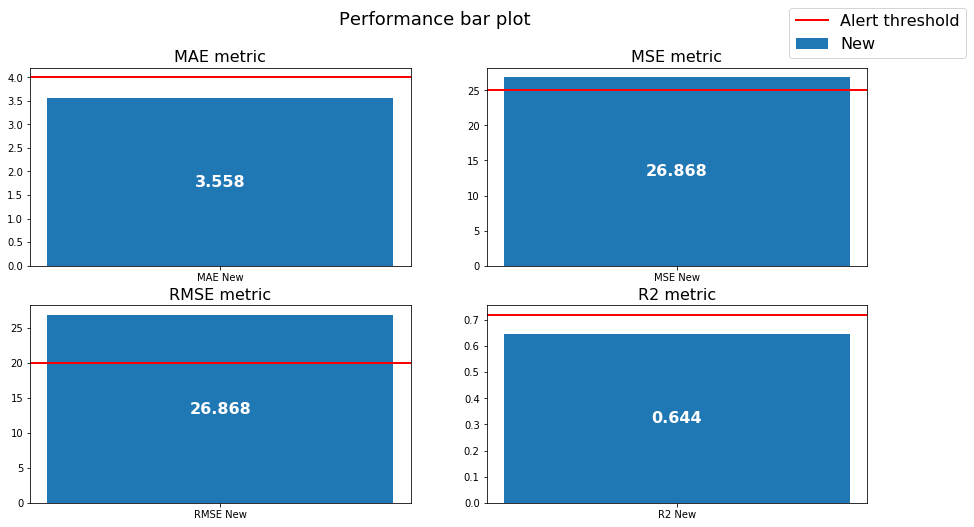

In [36]:
monitoring.plot_perfomance()

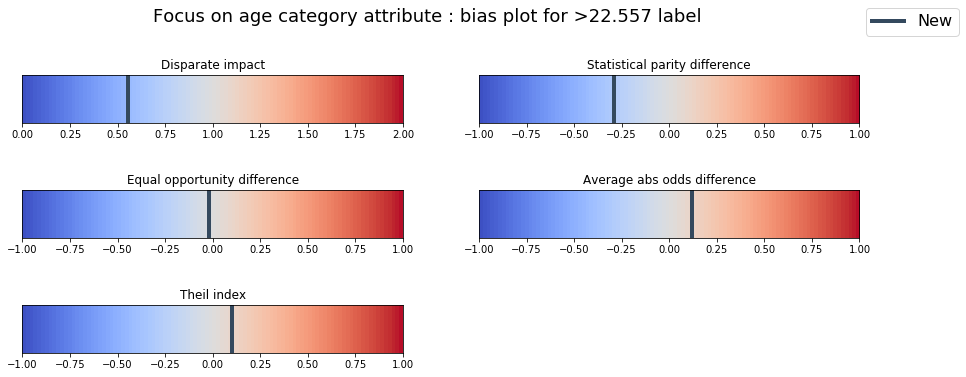

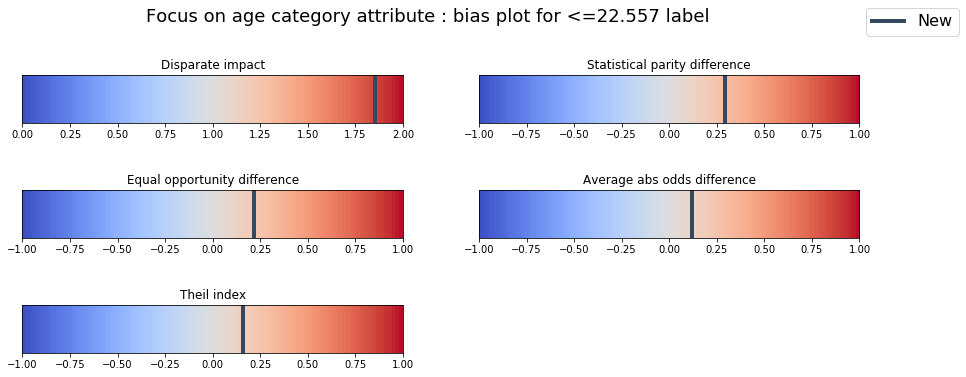

In [38]:
monitoring.plot_model_bias()

## Case 2 : New X, predictions and original dataset bias metrics

In [39]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        orig_metrics=orig_metrics,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='regression')

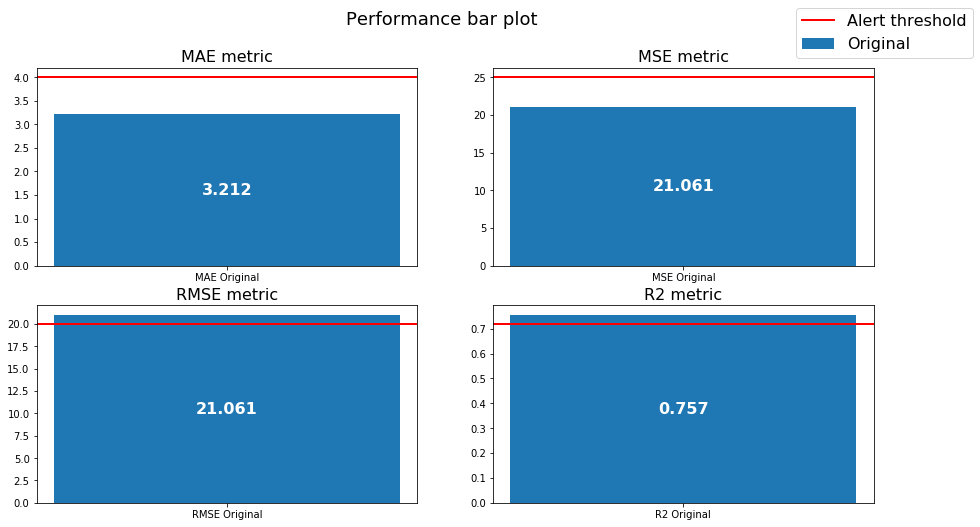

In [40]:
monitoring.plot_perfomance()

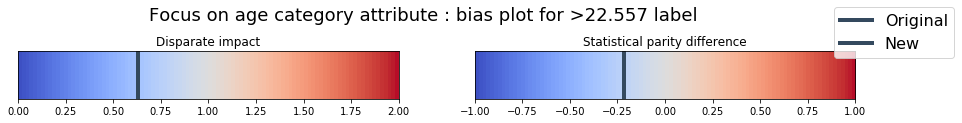

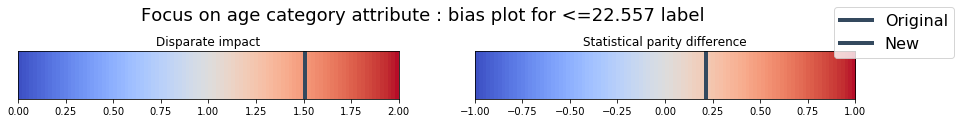

In [41]:
monitoring.plot_dataset_bias()

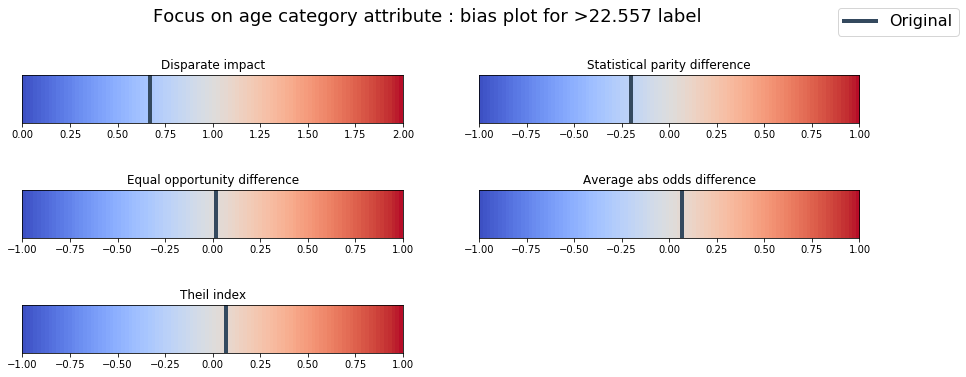

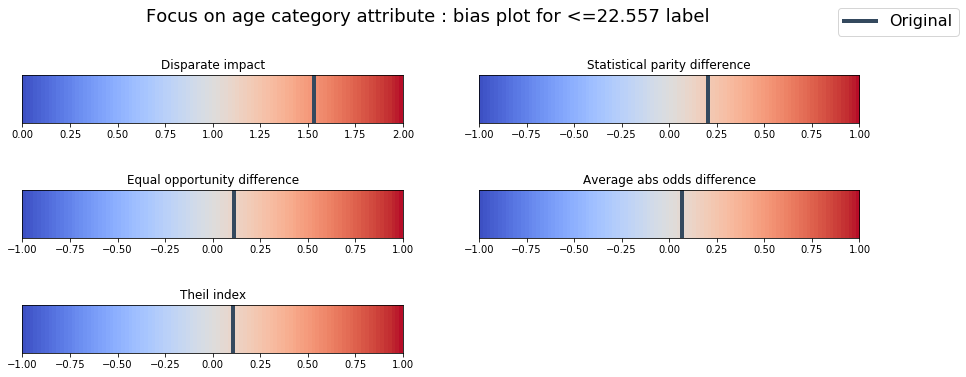

In [42]:
monitoring.plot_model_bias()

## Case 3 : New X, predictions, y real and original metrics

**IMPORTANT** : with regression, if you want to analyse bias please add mean attribute as the same when training.

You can find it by seing the `bias_dataset` or `bias_model` dictionnary above.

In [47]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        y_real=new_y_real,
                        orig_metrics=orig_metrics,
                        privileged_groups=privileged_groups,
                        alert_threshold=alert_threshold,
                        model_type='regression', mean=22.557)

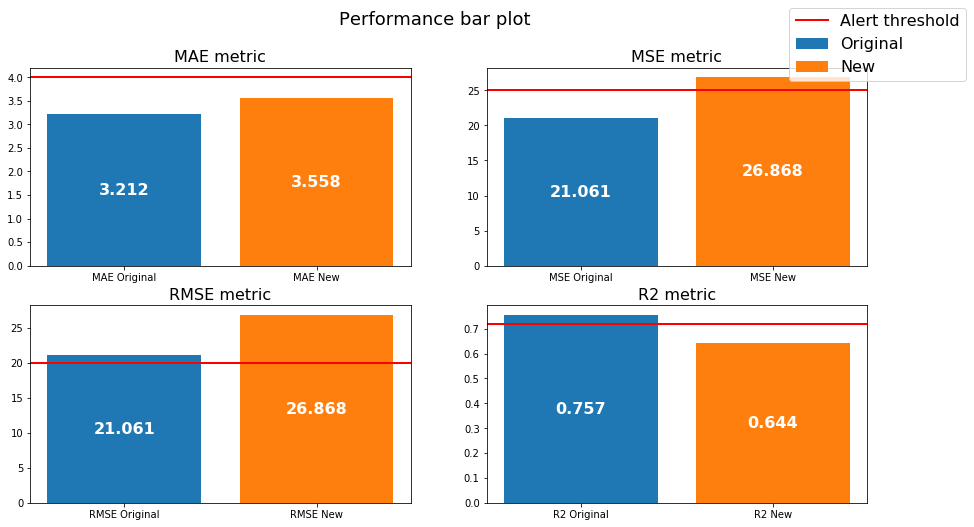

In [48]:
monitoring.plot_perfomance()

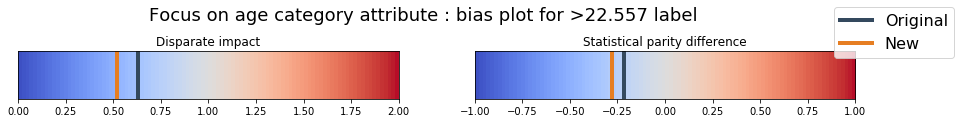

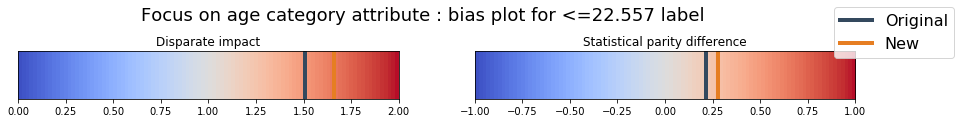

In [49]:
monitoring.plot_dataset_bias()

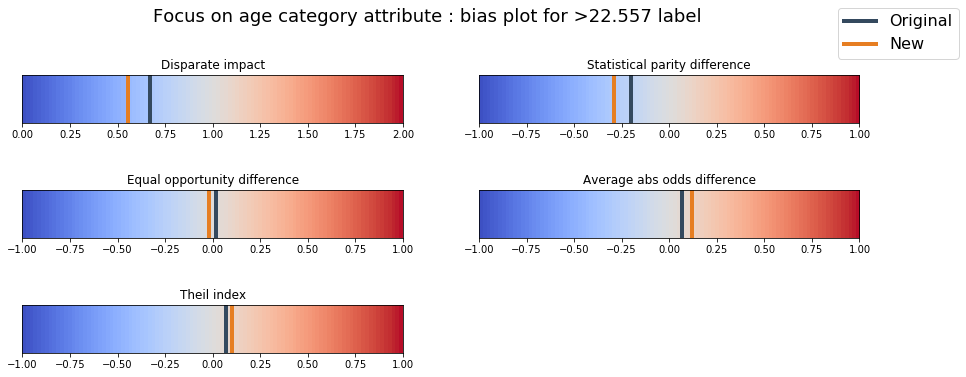

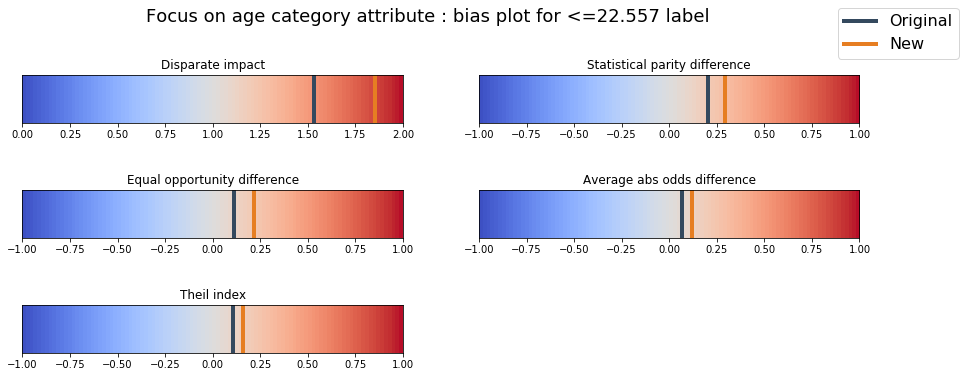

In [50]:
monitoring.plot_model_bias()

## The end.